In [68]:
import pandas as pd
import pandas_gbq
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'bigquery-public-data'
pandas_gbq.context.dialect = 'standard'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Load Data

The BigQuery Python client library provides a magic command that allows you to run queries with minimal code.

The BigQuery client library provides a cell magic, %%bigquery. The %%bigquery magic runs a SQL query and returns the results as a pandas `DataFrame`

TODO:
- [ ] Slide 1 - Executive Summary
- [ ] Slide 2 - Brooklyn vs rest of NY, why is Brooklyn an issue?
- [ ] Slide 3 - Focus on Brooklyn: main causes, day of accidents, correlation with weather, map of incidents
- [ ] Slide 4 - Recommendations: Dashboard with live updates, campaign against distraction, future steps (correlation with weather)
- [ ] Slide 5 - Technicalities and approach taken to analysis 

## Slide 2 - Brooklyn vs rest of NY, why is Brooklyn an issue?

In [69]:
%%bigquery injured_df
#number of injured per day, by borough
SELECT
  date(timestamp) as date,
  borough,
  SUM(number_of_persons_injured) as tot_injured
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough,
  date(timestamp) 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10155/10155 [00:03<00:00, 2709.24rows/s]


In [70]:
injured_df

,date,borough,tot_injured
0,2018-01-17,QUEENS,20
1,2015-05-08,MANHATTAN,29
2,2017-11-22,QUEENS,28
3,2017-12-05,BRONX,11
4,2017-11-03,BRONX,27
...,...,...,...
10150,2016-06-05,STATEN ISLAND,2
10151,2015-01-11,STATEN ISLAND,2
10152,2015-02-25,STATEN ISLAND,0
10153,2014-08-23,STATEN ISLAND,6


In [71]:
injured_df['date'] = pd.to_datetime(injured_df['date'])
injuries_count = injured_df.groupby(['date', 'borough']).sum().reset_index()
injuries_count['tot_injured_MA14'] = injuries_count.groupby('borough')['tot_injured'].rolling(14).mean().reset_index(0,drop=True)

In [72]:
#monthly
injuries_count = injured_df.groupby(['date', 'borough']).sum().reset_index()
injuries_count_m = injuries_count.set_index('date').groupby([pd.Grouper(freq='M'), 'borough']).sum().reset_index()
injuries_count_m['tot_injured_MA3'] = injuries_count_m.groupby('borough')['tot_injured'].\
rolling(3).mean().reset_index(0,drop=True)

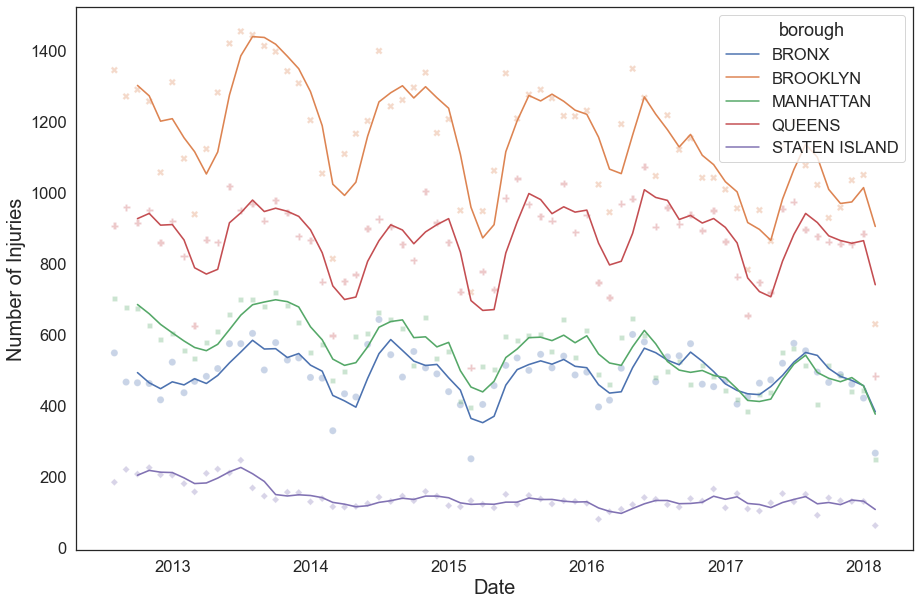

In [73]:
#monthly
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x = 'date', y = 'tot_injured', data = injuries_count_m, hue = 'borough', ax = ax, style = 'borough', s=50, alpha = 0.3, legend = False)
g = sns.lineplot(x= 'date' , y= 'tot_injured_MA3', data = injuries_count_m, hue = 'borough', ax = ax, linewidth = 1.6)

ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Number of Injuries', fontsize = 20)
fig.savefig(f'figures/monthly_injured.png', format='png', dpi=1000)

In [74]:
%%bigquery collisions_df
#number of collisions per day, by borough
SELECT
  date(timestamp) as date,
  borough,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough,
  date(timestamp) 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10155/10155 [00:02<00:00, 4050.62rows/s]


In [75]:
collisions_df

,date,borough,tot_collisions
0,2018-01-17,QUEENS,104
1,2015-05-08,MANHATTAN,132
2,2017-11-22,QUEENS,135
3,2017-12-05,BRONX,49
4,2017-11-03,BRONX,85
...,...,...,...
10150,2016-06-05,STATEN ISLAND,5
10151,2015-01-11,STATEN ISLAND,11
10152,2015-02-25,STATEN ISLAND,1
10153,2014-08-23,STATEN ISLAND,9


In [76]:
#monthly
collisions_df['date'] = pd.to_datetime(collisions_df['date'])
collisions_count = collisions_df.groupby(['date', 'borough']).sum().reset_index()
collisions_count_m = collisions_count.set_index('date').groupby([pd.Grouper(freq='M'), 'borough']).sum().reset_index()
collisions_count_m['tot_collisions_MA6'] = collisions_count_m.groupby('borough')['tot_collisions'].\
rolling(3).mean().reset_index(0,drop=True)

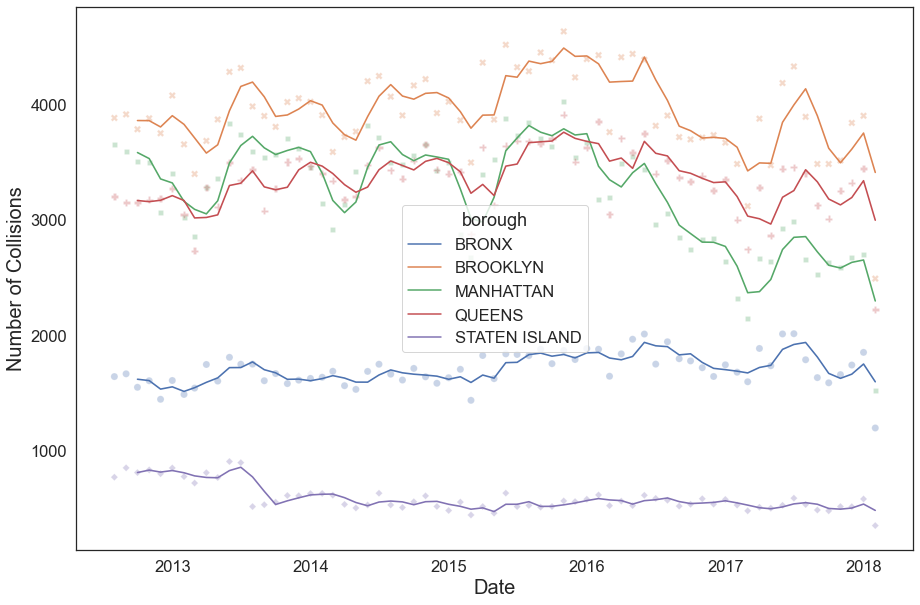

In [77]:
#monthly
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x = 'date', y = 'tot_collisions', data = collisions_count_m, hue = 'borough', ax = ax, style = 'borough', s=50, alpha = 0.3, legend = False)
g = sns.lineplot(x= 'date' , y= 'tot_collisions_MA6', data = collisions_count_m, hue = 'borough', ax = ax, linewidth = 1.6)

ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Number of Collisions', fontsize = 20)
fig.savefig(f'figures/monthly_collisions.png', format='png', dpi=1000)

In [78]:
%%bigquery killed_df
#number of PERSON KILLED by borough
SELECT
  borough,
  SUM(number_of_persons_killed) as tot_kills
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26rows/s]


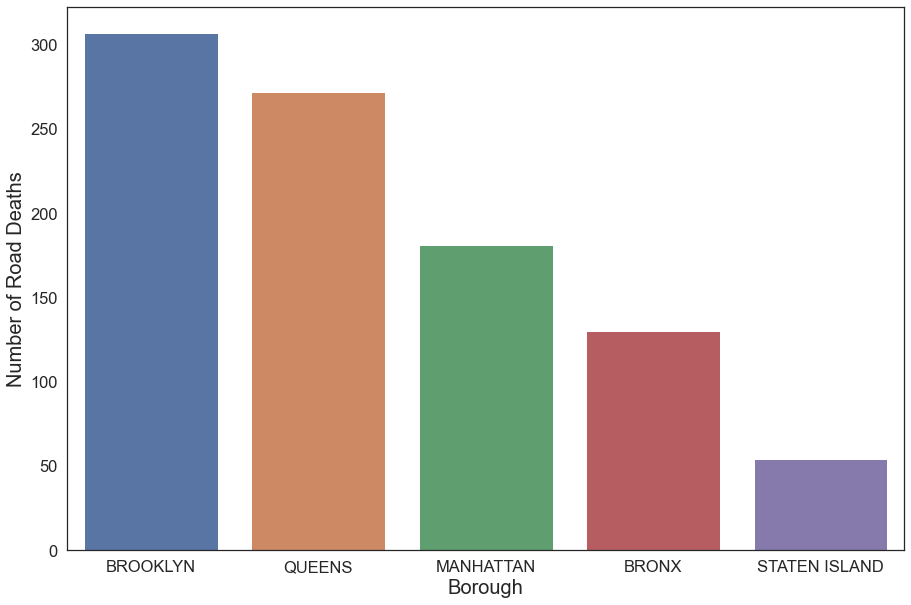

In [79]:
plt.figure(figsize=(15,10))
killed_df.sort_values(by = 'tot_kills', inplace = True, ascending = False)
sns.set(font_scale=1.5)
sns.set_style("white")
ax = sns.barplot(x="borough", y="tot_kills", data=killed_df)
ax.set_xlabel('Borough', fontsize = 20)
ax.set_ylabel('Number of Road Deaths', fontsize = 20)
fig.savefig(f'figures/road_death.png', format='png', dpi=1000)

In [80]:
%%bigquery killed_df_acc_type
#number of collisions per day, by borough
SELECT
  borough,
  SUM(number_of_motorist_killed) as tot_kills_motorist,
  SUM(number_of_cyclist_killed) as tot_kills_cyclist,
  SUM(number_of_pedestrians_killed) as tot_kills_pedestrian
    
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough != ''
GROUP BY
  borough

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96rows/s]


In [81]:
killed_df_acc_type

,borough,tot_kills_motorist,tot_kills_cyclist,tot_kills_pedestrian
0,QUEENS,98,20,154
1,MANHATTAN,23,20,140
2,BRONX,44,9,77
3,STATEN ISLAND,31,2,22
4,BROOKLYN,101,29,177


In [82]:
killed_df_acc_type = killed_df_acc_type.melt(id_vars=["borough"], 
        var_name="acc_type", 
        value_name="tot_kills")

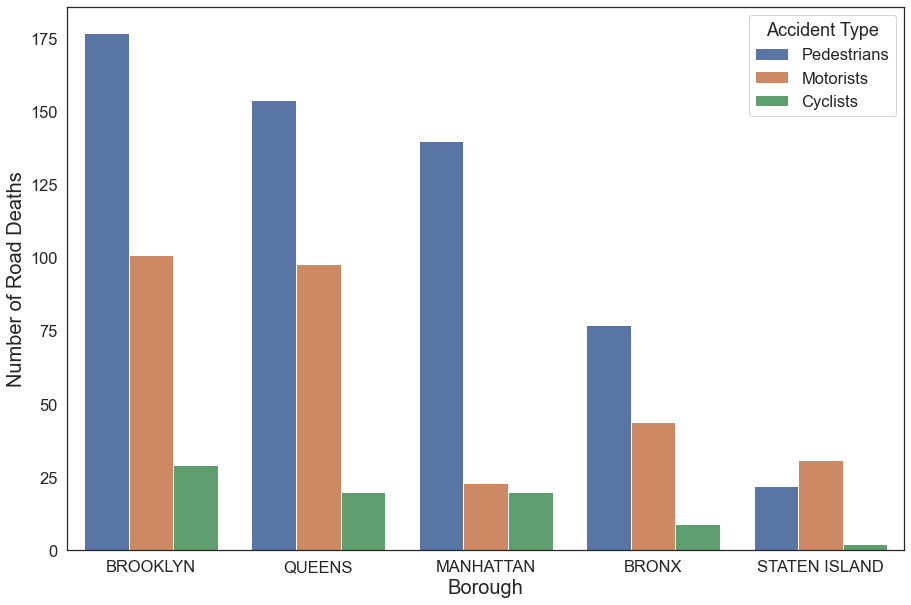

In [83]:
plt.figure(figsize=(15,10))
killed_df_acc_type.sort_values(by = 'tot_kills', inplace = True, ascending = False)
sns.set(font_scale=1.5)
sns.set_style("white")
ax = sns.barplot(x="borough", y="tot_kills", hue = 'acc_type', data=killed_df_acc_type)
ax.set_xlabel('Borough', fontsize = 20)
ax.set_ylabel('Number of Road Deaths', fontsize = 20)

# title
new_title = 'Accident Type'
new_labels = ['Pedestrians', 'Motorists', 'Cyclists']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels, title=new_title, loc="upper right")
ax.set_xlabel('Borough', fontsize = 20)
ax.set_ylabel('Number of Road Deaths', fontsize = 20)
fig.savefig(f'figures/road_death_by_type.png', format='png', dpi=1000)

# Slide 3 - Focus on Brooklyn: Brooklyn big picture: causes, hours and days of accidents, ZIP codes most hit

In [84]:
%%bigquery contri_df
#top 10 contributing factors in brooklyn (we remove unspecified values)
SELECT
  contributing_factor_vehicle_1 as contri_factor,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN' and contributing_factor_vehicle_1 != 'Unspecified' and contributing_factor_vehicle_1 != ''
GROUP BY
  contributing_factor_vehicle_1

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.66rows/s]


In [85]:
contri_df.sort_values(by = 'tot_collisions', ascending = False)[:10]

,contri_factor,tot_collisions
3,Driver Inattention/Distraction,30524
4,Failure to Yield Right-of-Way,14382
8,Backing Unsafely,8805
6,Fatigued/Drowsy,7870
15,Lost Consciousness,5020
10,Other Vehicular,4934
16,Turning Improperly,4142
2,Following Too Closely,3967
12,Prescription Medication,3788
7,Traffic Control Disregarded,3591


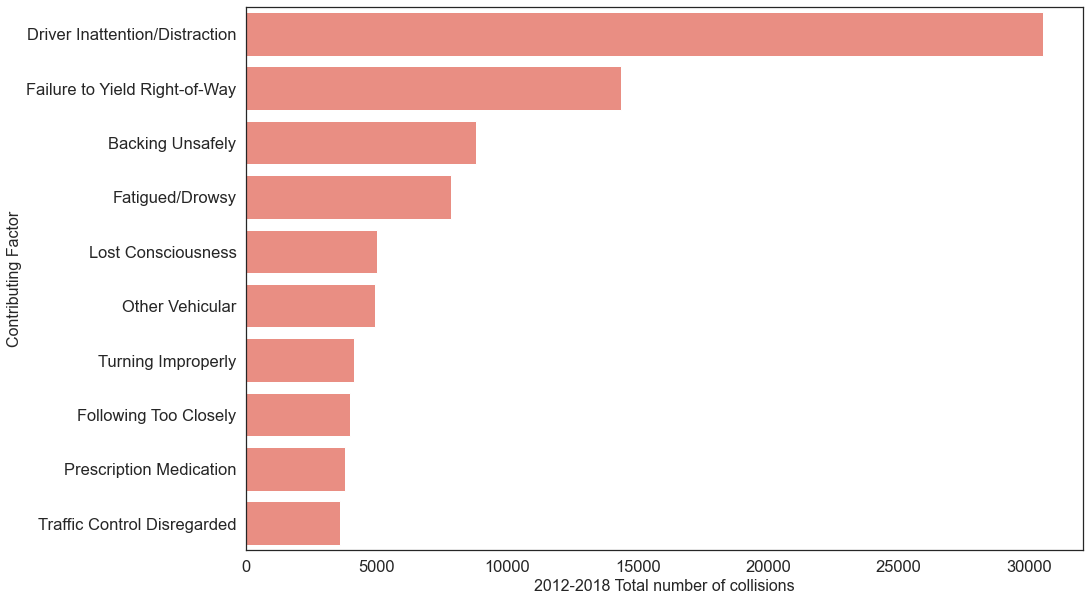

In [86]:
contri_df.sort_values(by = 'tot_collisions', inplace = True, ascending = False)

plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.set_style("white")
ax = sns.barplot(x="tot_collisions", y="contri_factor", data=contri_df[:10], color = 'salmon')

ax.set_ylabel('Contributing Factor', fontsize = 16)
ax.set_xlabel('2012-2018 Total number of collisions', fontsize = 16)

# title
fig.savefig(f'figures/collisions_by_contri.png', format='png', dpi=1000)

In [87]:
%%bigquery day_hour_df
#hours and day of accidents
SELECT
  timestamp as date,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN'
GROUP BY
  timestamp

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198054/198054 [00:02<00:00, 75057.13rows/s]


In [88]:
#dates feature engineering
day_hour_df['date'] = pd.to_datetime(day_hour_df['date'] )
day_hour_df['day_of_week'] = day_hour_df['date'].dt.day_name()
day_hour_df['date_hour'] = day_hour_df['date'].dt.hour
day_hour_df

,date,tot_collisions,day_of_week,date_hour
0,2016-10-22 23:10:00+00:00,6,Saturday,23
1,2013-09-30 07:00:00+00:00,7,Monday,7
2,2016-10-30 16:10:00+00:00,10,Sunday,16
3,2015-06-24 18:00:00+00:00,5,Wednesday,18
4,2017-12-01 18:00:00+00:00,5,Friday,18
...,...,...,...,...
198049,2016-12-08 19:12:00+00:00,4,Thursday,19
198050,2012-08-29 15:00:00+00:00,4,Wednesday,15
198051,2013-05-18 13:00:00+00:00,4,Saturday,13
198052,2016-10-27 10:10:00+00:00,4,Thursday,10


In [89]:
#hours and day of accidents
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour_df['day_of_week'] = pd.Categorical(day_hour_df['day_of_week'], categories=cats, ordered=True)
day_hour_df = day_hour_df.sort_values('day_of_week')
dayHour = day_hour_df.groupby(by=['day_of_week', 'date_hour']).sum()['tot_collisions'].unstack()
dayHour.head()

date_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
Monday,855,448,298,245,294,360,785,1196,2592,2583,...,2714,2666,3162,2996,2480,1949,1588,1237,1029,790
Tuesday,762,366,259,192,200,285,731,1217,2561,2707,...,2718,2524,3122,3125,2677,1982,1699,1308,1082,794
Wednesday,765,368,266,191,239,295,720,1191,2501,2389,...,2748,2491,3012,3001,2654,2056,1685,1348,1126,797
Thursday,804,372,271,199,242,329,700,1153,2570,2563,...,2741,2491,2997,2986,2560,2039,1629,1362,1174,828
Friday,920,495,364,256,283,366,719,1076,2519,2489,...,2986,2647,3157,2961,2517,2086,1749,1450,1278,1087


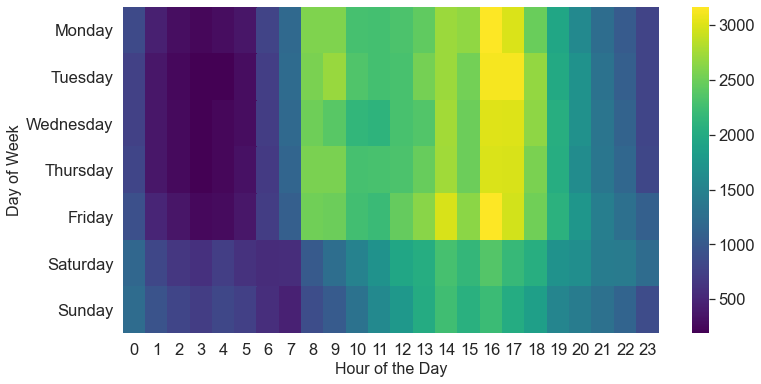

In [90]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(dayHour, cmap='viridis')

ax.set_xlabel('Hour of the Day', fontsize = 16)
ax.set_ylabel('Day of Week', fontsize = 16)

# title
fig.savefig(f'figures/collisions_heatmap.png', format='png', dpi=1000)

## Slide 4 - Focus on Brooklyn : Focus on causes and day of weeks for actionable insights

In [91]:
%%bigquery contri_df_weekdays
#top 10 contributing factors in brooklyn (we remove unspecified values)
SELECT
  timestamp as date,
  contributing_factor_vehicle_1 as contri_factor,
  COUNT(unique_key) as tot_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = 'BROOKLYN' and contributing_factor_vehicle_1 != 'Unspecified' and contributing_factor_vehicle_1 != ''
GROUP BY
  timestamp,
  contributing_factor_vehicle_1

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112131/112131 [00:02<00:00, 39498.17rows/s]


In [92]:
contri_df_weekdays

,date,contri_factor,tot_collisions
0,2017-11-13 07:10:00+00:00,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,1
1,2017-07-04 14:05:00+00:00,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,1
2,2017-12-08 15:00:00+00:00,Steering Failure,1
3,2013-05-16 16:30:00+00:00,Fell Asleep,1
4,2017-10-30 15:46:00+00:00,Steering Failure,1
...,...,...,...
112126,2015-08-12 15:46:00+00:00,Reaction to Other Uninvolved Vehicle,1
112127,2015-04-07 17:48:00+00:00,Reaction to Other Uninvolved Vehicle,1
112128,2013-01-15 14:31:00+00:00,Reaction to Other Uninvolved Vehicle,1
112129,2014-06-16 18:25:00+00:00,Reaction to Other Uninvolved Vehicle,1


In [93]:
#dates feature engineering
contri_df_weekdays['date'] = pd.to_datetime(contri_df_weekdays['date'] )
contri_df_weekdays['day_of_week'] = contri_df_weekdays['date'].dt.day_name()
contri_df_weekdays['date_hour'] = contri_df_weekdays['date'].dt.hour
contri_df_weekdays['date_day'] = contri_df_weekdays['date'].dt.date
contri_df_weekdays['is_wknd'] = contri_df_weekdays['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

#only keep top 20 causes
top_20_causes = contri_df.sort_values(by = 'tot_collisions', ascending = False)[:20].contri_factor.to_list()
contri_df_weekdays = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(top_20_causes)]
contri_df_weekdays.head()

,date,contri_factor,tot_collisions,day_of_week,date_hour,date_day,is_wknd
5755,2013-09-30 07:00:00+00:00,Fatigued/Drowsy,1,Monday,7,2013-09-30,0
5756,2013-07-21 19:35:00+00:00,Fatigued/Drowsy,1,Sunday,19,2013-07-21,1
5757,2014-11-26 07:20:00+00:00,Fatigued/Drowsy,1,Wednesday,7,2014-11-26,0
5758,2014-08-15 19:00:00+00:00,Fatigued/Drowsy,1,Friday,19,2014-08-15,0
5759,2013-09-19 18:30:00+00:00,Fatigued/Drowsy,1,Thursday,18,2013-09-19,0


<AxesSubplot:xlabel='contri_factor', ylabel='contri_factor'>

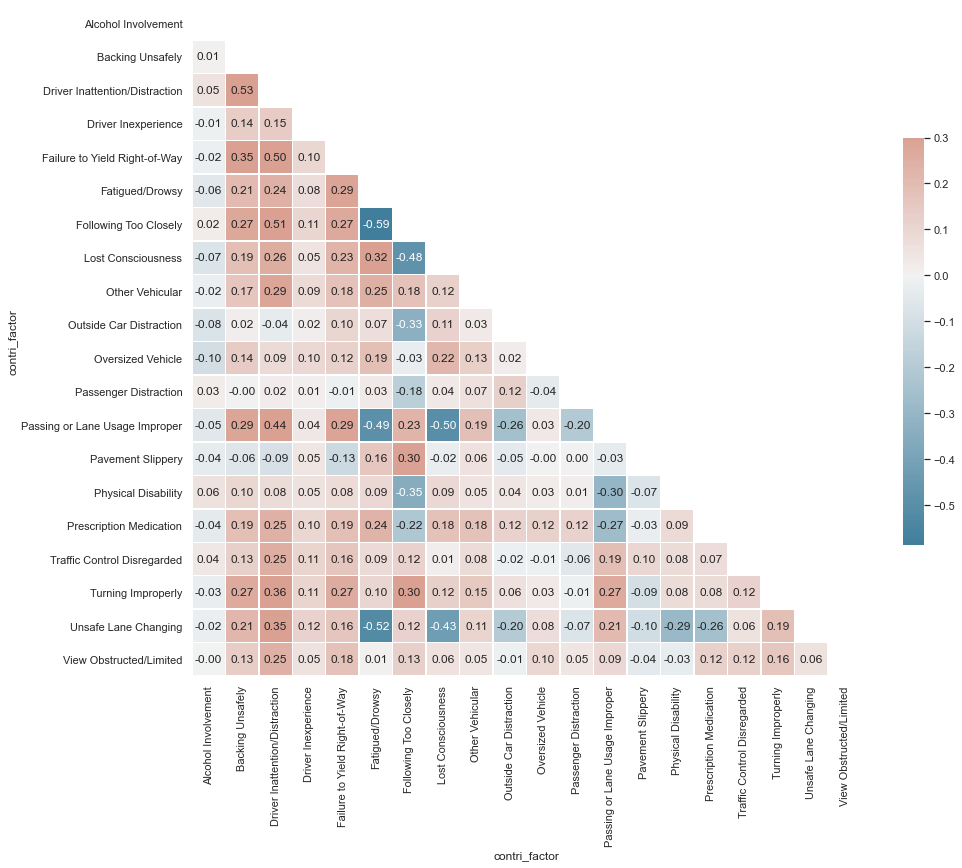

In [108]:
#driver inattention is higher during the weekdays, in particular during business hours
contri_df_day = contri_df_weekdays.groupby(['date_day', 'contri_factor']).sum()['tot_collisions'].reset_index()
contri_df_pivot = contri_df_day.pivot_table('tot_collisions', 'date_day', 'contri_factor').reset_index()

# Compute the correlation matrix
corr = contri_df_pivot.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1)
sns.set_style("white")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt='.2f')


In [112]:
corr_features

['Backing Unsafely',
 'Driver Inattention/Distraction',
 'Failure to Yield Right-of-Way',
 'Following Too Closely',
 'Passing or Lane Usage Improper',
 'Turning Improperly',
 'Unsafe Lane Changing']

Text(0, 0.5, 'Number of Collisions')

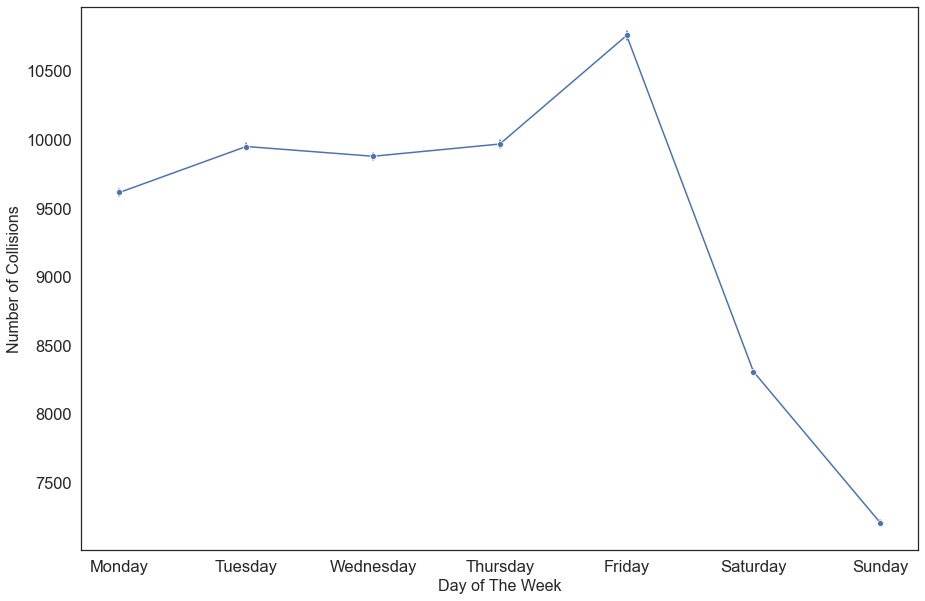

In [124]:
corr_features = [column for column in corr.columns if corr.loc['Driver Inattention/Distraction', column] >= 0.3]
contri_df_inattention = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(corr_features)].copy()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
contri_df_inattention['day_of_week'] = pd.Categorical(contri_df_inattention['day_of_week'], categories=cats, ordered=True)
contri_df_inattention = contri_df_inattention.sort_values('day_of_week')

sns.set(font_scale=1.5)
sns.set_style("white")
plt.figure(figsize=(15,10))
ax = sns.lineplot(
    data=contri_df_inattention, x="day_of_week", y="tot_collisions",err_style="bars", ci=68, sort = False, estimator = np.sum, marker = 'o'
)
ax.set_xlabel('Day of The Week', fontsize = 16)
ax.set_ylabel('Number of Collisions', fontsize = 16)

<AxesSubplot:xlabel='tot_collisions', ylabel='is_wknd'>

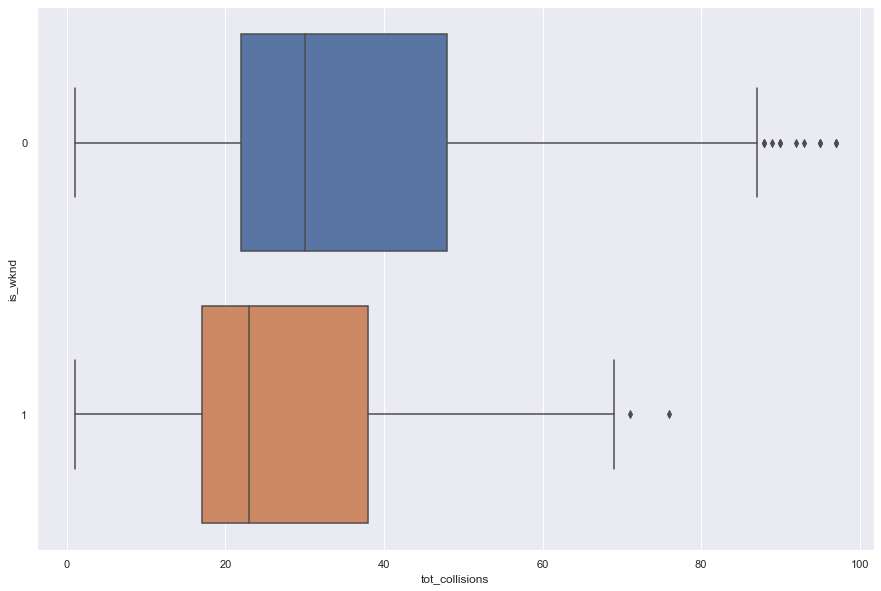

In [97]:
plt.figure(figsize=(15,10))
sns.boxplot(data = contri_df_inattention.groupby(['is_wknd', 'date_day']).sum().reset_index(), y = 'is_wknd', x = 'tot_collisions', orient = 'h')

In [115]:
contri_df_alcohol

,date,contri_factor,tot_collisions,day_of_week,date_hour,date_day,is_wknd
41844,2013-07-08 14:01:00+00:00,Alcohol Involvement,1,Monday,14,2013-07-08,0
42689,2017-04-17 16:04:00+00:00,Alcohol Involvement,1,Monday,16,2017-04-17,0
41081,2016-12-26 05:58:00+00:00,Alcohol Involvement,1,Monday,5,2016-12-26,0
42691,2017-07-03 23:40:00+00:00,Alcohol Involvement,1,Monday,23,2017-07-03,0
42128,2014-11-24 02:45:00+00:00,Alcohol Involvement,1,Monday,2,2014-11-24,0
...,...,...,...,...,...,...,...
41360,2012-12-30 00:15:00+00:00,Alcohol Involvement,1,Sunday,0,2012-12-30,1
42344,2014-09-21 01:30:00+00:00,Alcohol Involvement,1,Sunday,1,2014-09-21,1
42348,2017-03-05 20:37:00+00:00,Alcohol Involvement,1,Sunday,20,2017-03-05,1
41374,2016-10-09 04:10:00+00:00,Alcohol Involvement,1,Sunday,4,2016-10-09,1


Text(0, 0.5, 'Number of Collisions')

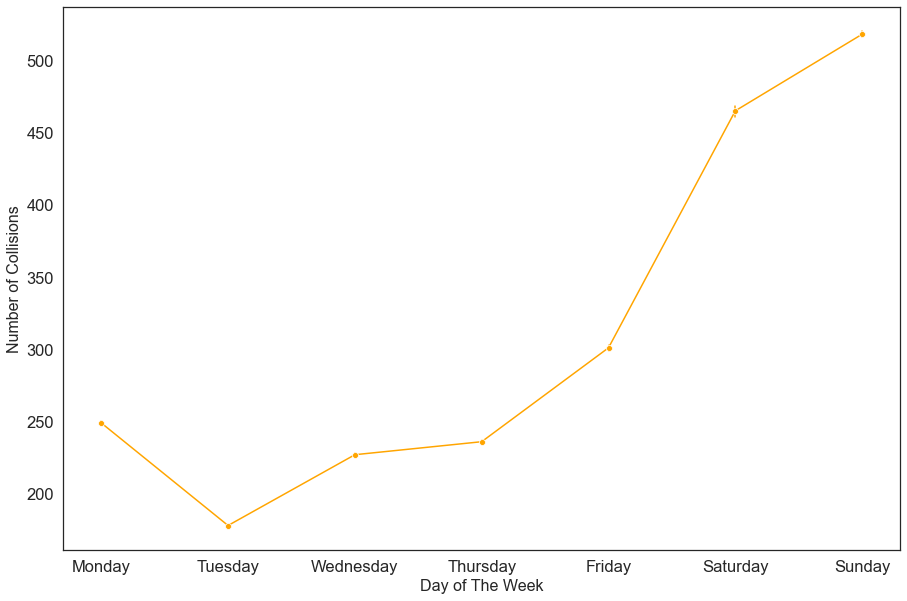

In [126]:
#alchol involvement is higher during the weekends
contri_df_alcohol = contri_df_weekdays[contri_df_weekdays['contri_factor'].isin(['Alcohol Involvement'])].copy()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
contri_df_alcohol['day_of_week'] = pd.Categorical(contri_df_alcohol['day_of_week'], categories=cats, ordered=True)
contri_df_alcohol = contri_df_alcohol.sort_values('day_of_week')

sns.set(font_scale=1.5)
sns.set_style("white")
plt.figure(figsize=(15,10))
ax = sns.lineplot(
    data=contri_df_alcohol, x="day_of_week", y="tot_collisions",err_style="bars", ci=68, sort = False, estimator = np.sum, marker = 'o', color = 'orange'
)
ax.set_xlabel('Day of The Week', fontsize = 16)
ax.set_ylabel('Number of Collisions', fontsize = 16)

<AxesSubplot:xlabel='tot_collisions', ylabel='is_wknd'>

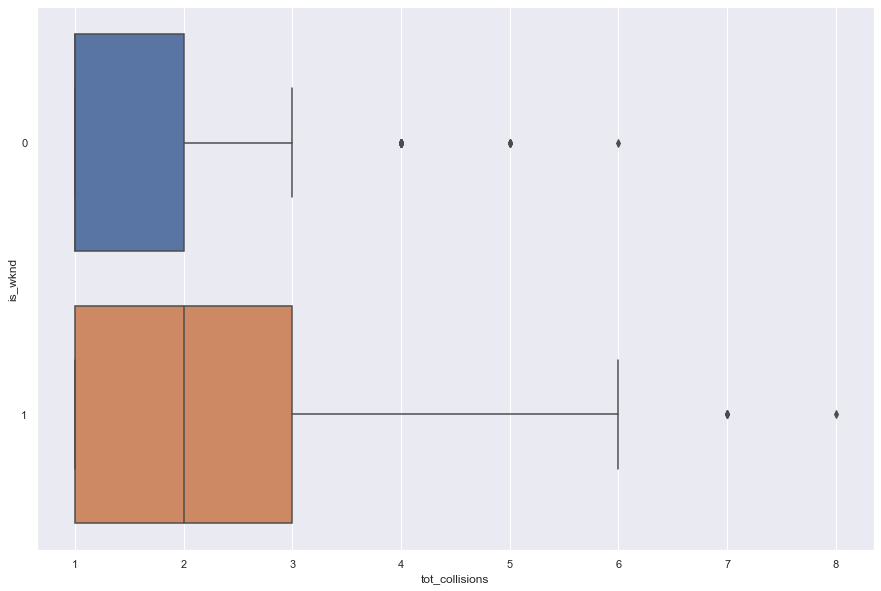

In [99]:
plt.figure(figsize=(15,10))
sns.boxplot(data = contri_df_alcohol.groupby(['is_wknd', 'date_day']).sum().reset_index(), y = 'is_wknd', x = 'tot_collisions', orient = 'h')